In [4]:
#import the python scientific suite
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn
import seaborn as sns
import scipy
import pylab

/Users/Franklin/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [5]:
from collections import defaultdict

In [7]:
# This is importing a "future" python version 3 print function.
from __future__ import print_function
from __future__ import division
#plot figures inline in Jupyter notebooks
%matplotlib inline 

#use seaborn for plotting
sns.set()
sns.set_context('paper', font_scale = 1.5)
sns.set_style('ticks')
pylab.rcParams.update({'figure.autolayout': True})

In [90]:
#define some helper functions 
def CountInstance(df, col_name):

    name, counts = np.unique(df[col_name], return_counts = True)
    counts_df = pd.DataFrame(data = {col_name: name, ('n_'+ col_name):counts})
    merged_df = pd.merge(df, counts_df, on = col_name, how = 'left')
    
    return(merged_df)

def TopChains(df, cutoff):
    #
    # Find the top chains
    # include a dataframe with column 'business_name'
    
    name, counts = np.unique(df['name'], return_counts = True)
    counts_df = pd.DataFrame(data = {'name': name, 'counts':counts})
    top_chains = counts_df.sort_values(by = 'counts', ascending = False)
    top_chains.index = range(len(top_chains)) #re-index
    
    return list(top_chains['name'][top_chains['counts'] > cutoff])

def RollingGaussianMean(df, x, y, centers, eps):
    df = df.dropna()
    rolling = [] #start a list to hold the rolling mean
    for bc in centers: #for each bin center in the list of bin centers
            w = scipy.stats.norm.pdf((df[x] - bc)/(eps))
            if sum(w) != 0.0:
                rolling.append((bc, np.average(df[y], weights = w))) #take the mean and add it to the stack
            else:
                rolling.append((bc, np.average(df[y])))
    return(pd.DataFrame(rolling).rename(columns = {0: 'x', 1: 'y'}))

In [101]:
#read in the data from the files
file_dir = '/Volumes/1TB_BAY/yelp_dataset_challenge_academic_dataset/' #replace this with the path to your data files

f = {'R': 'R_review_stat.csv', 'T': 'T_review_text.csv', 'N': 'N_neighborhood.csv',\
    'B': 'B_business.csv', 'U': 'U_user.csv'}

d = defaultdict() #initialize an empty dictionary to hold the dataframes

for fi in f: #for each file in the dictinary of files
    d[fi] = pd.read_csv(file_dir + f[fi]) #read in the files and hold them in the dataframe dictionary

In [72]:
print(d.keys()) #the list of files in the data dictionary

['R', 'B', 'U', 'T', 'N']


The object 'd' is our data dictionary. It contains five dataframes that are the entirety of the combined yelp and zillow datasets. For example, let's access the review statistics:

In [97]:
d['R'].head()

,Unnamed: 0,review_id,words,sentences,ease,grade,dale_chall,stars,business_id,z_hood,latest_zhvi,latest_sqft,lat,lon,bbox_area,polarity,subjectivity,year,user_id
0,0,6ZWmWypGMdnwwavY8ykXlg,197,13,73.17,6.8,6.62,4,uI0LvTXFACid1308KFO5ew,343635,NaN,NaN,40.392222,-79.947974,5.378061,0.260963,0.527941,2009.624658,iTmWHtltCtk0Gm55AOxrUA
1,1,3m6vLe955opYMSrTrlLIKw,385,25,90.09,4.4,6.10,2,uI0LvTXFACid1308KFO5ew,343635,NaN,NaN,40.392222,-79.947974,5.378061,0.009410,0.485827,2011.197260,JEvkfVPf_DuhX-ntE5L6bQ
2,2,MkHaKWwZ_OngdUsMt_xAqg,55,4,92.12,3.6,7.15,2,uI0LvTXFACid1308KFO5ew,343635,NaN,NaN,40.392222,-79.947974,5.378061,0.190000,0.580000,2011.438356,QOdrDkYXhqA8jtPzfpugWQ
3,3,gB-kzO-Jg_u2p7Cmf9xG_w,206,12,79.60,6.4,6.70,4,uI0LvTXFACid1308KFO5ew,343635,NaN,NaN,40.392222,-79.947974,5.378061,0.324351,0.606169,2011.586301,qPGLUQUG43b3aBZKDUBlMw
4,4,cCh6xPIcV6P2ben4bCsq7Q,208,9,65.05,9.9,8.19,3,uI0LvTXFACid1308KFO5ew,343635,NaN,NaN,40.392222,-79.947974,5.378061,0.209776,0.511859,2011.679452,lJsCDFtnR2-AMhDdWtCRug


The first operation we will perform is the filtration of the data, to only include certain neighborhoods, businesses, and users. We usually want to apply filters to remove users and businesses with a small number of reviews. 

In [ ]:
#begin filtration of data based on multiple criteria
min_reviews_per_business = 3
min_reviews_per_user = 5
min_business_per_neighborhood = 20

#perform the filtration by updating the dataframes
d['B'] = d['B'][(d['B']['review_count'] >= min_reviews_per_business)]
d['U'] = d['U'][(d['U']['n_reviews'] >= min_reviews_per_user)]
d['N'] = d['N'][(d['N']['n'] >= min_business_per_neighborhood)]

In [102]:
min_stores_per_chain = 35
top_chains = TopChains(d['B'], min_stores_per_chain) #list of all of the chains with over a certain number of reviews
print(top_chains)

['Starbucks', 'Subway', "McDonald's", 'Walgreens', 'Taco Bell', 'Pizza Hut', 'The UPS Store', "Wendy's", 'Burger King', 'Bank of America', 'Wells Fargo Bank', 'Circle K', 'Great Clips', "Domino's Pizza", 'Panda Express', "Dunkin' Donuts", 'Chase Bank', 'Supercuts', 'Chipotle Mexican Grill', 'Jiffy Lube', 'US Post Office', 'QuikTrip', "Jimmy John's", "Papa John's Pizza", 'KFC', 'Enterprise Rent-A-Car', 'Dairy Queen', 'Cvs Pharmacy', 'Jack in the Box', 'FedEx Office Print & Ship Center', 'T-Mobile', "Denny's", "Arby's"]


In this next cell, we will learn how to loop through individual users, businesses, or neighborhoods. In this case we will loop through individual businesses. For each business, we will create a temporary dataframe in the loop, containing the review statistics for that business

In [104]:
for ids in np.unique(d['B']['business_id'])[0:10]: #for the unique business IDs 
    r = d['R'][d['R']['business_id'] == ids]
    
r.head() #let's see some of the review stats of this particular business, notice how all of the business ids are the same

,Unnamed: 0,review_id,words,sentences,ease,grade,dale_chall,stars,business_id,z_hood,latest_zhvi,latest_sqft,lat,lon,bbox_area,polarity,subjectivity,year,user_id
910023,910023,qoDP0T3iT3f98hdzOO5ARw,82,6,66.74,7.2,7.55,5,--pOlFxITWnhzc7SHSIP0A,275101,471600.0,199.0,35.165215,-80.797661,1.385601,0.181593,0.542766,2013.208219,JG4BZ6PWmhB3XHgpRKaicQ
910024,910024,K4ZZINk_QMXsQQOqge9Sgw,179,10,79.60,6.4,7.04,3,--pOlFxITWnhzc7SHSIP0A,275101,471600.0,199.0,35.165215,-80.797661,1.385601,0.232818,0.470280,2013.210959,ts7EG6Zv2zdMDg29nyqGfA
910025,910025,o8nKXEuFxCKLN1o7dNjlTA,93,5,87.05,5.6,6.74,4,--pOlFxITWnhzc7SHSIP0A,275101,471600.0,199.0,35.165215,-80.797661,1.385601,0.207744,0.569024,2013.213699,wyukT5LzQ5CQJ1KMVuojIQ
910026,910026,CvM1tXAsVqnmQEYdXOSLag,423,21,76.56,7.6,7.69,4,--pOlFxITWnhzc7SHSIP0A,275101,471600.0,199.0,35.165215,-80.797661,1.385601,0.135623,0.458455,2013.213699,3Kn23qXbgPFmtV-CbHPJ2A
910027,910027,LxZMMG2kRXzyw2up0Seh-A,320,24,75.20,6.0,7.88,5,--pOlFxITWnhzc7SHSIP0A,275101,471600.0,199.0,35.165215,-80.797661,1.385601,0.298242,0.605697,2013.219178,A6bPFcUjuuayRBoyybedDQ


In the next cells, we will compute the trend of reviews over time in a random neighborhood. We will show a scatter plot of the review stars as a function of time.

27338


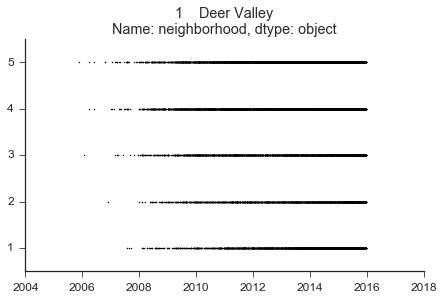

In [117]:
for ids in np.unique(d['N']['z_hood'])[1:2]: #for the unique business IDs 
    r = d['R'][d['R']['z_hood'] == ids]
    print(len(r))
    plt.figure()
    plt.title(str(d['N']['neighborhood'][d['N']['z_hood'] == ids]))
    plt.scatter(r['year'], r['stars'], lw = 0, s = 2, c = 'black')
    plt.ylim(0.5,5.5)
    sns.despine()

This shows that there were over 27,000 reviews in this neighborhood. This graph is a not easy to understand. It is hard to see how the distribution changes as a function of time. For this reason, I've created a helper function called RollingGaussianMean, which is a gaussian kernel smoother. Let's see how this one works.

27338


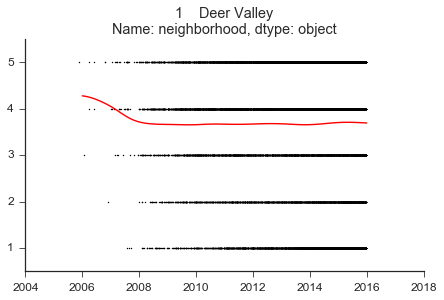

In [118]:
for ids in np.unique(d['N']['z_hood'])[1:2]: #for the unique business IDs 
    r = d['R'][d['R']['z_hood'] == ids]
    print(len(r))
    gm = RollingGaussianMean(r, 'year', 'stars', np.linspace(2006, 2016, 120), 0.5)
    plt.figure()
    plt.title(str(d['N']['neighborhood'][d['N']['z_hood'] == ids]))
    plt.scatter(r['year'], r['stars'], lw = 0, s = 2, c = 'black')
    plt.ylim(0.5,5.5)
    plt.plot(gm['x'], gm['y'], c = 'red')
    sns.despine()

Looks like the mean is static as a function of time after the year 2008. Note that we can perform this analysis for all of the neighborhoods by looping through them. Watch:

27338
1758
5516
38566


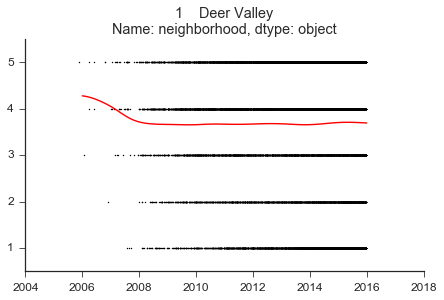

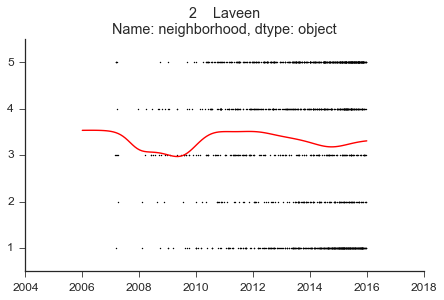

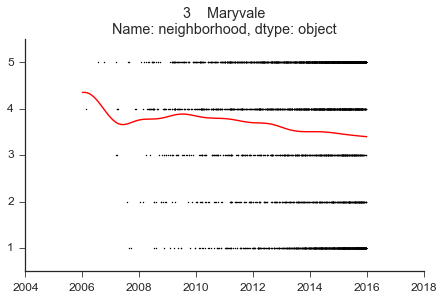

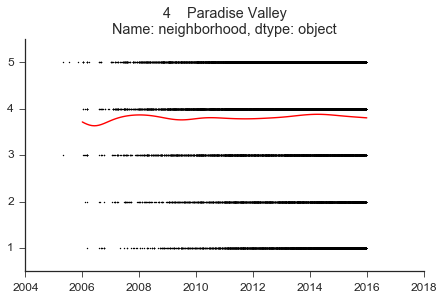

In [120]:
for ids in np.unique(d['N']['z_hood'])[1:5]: #for the unique business IDs 
    r = d['R'][d['R']['z_hood'] == ids]
    print(len(r))
    gm = RollingGaussianMean(r, 'year', 'stars', np.linspace(2006, 2016, 120), 0.5)
    plt.figure()
    plt.title(str(d['N']['neighborhood'][d['N']['z_hood'] == ids]))
    plt.scatter(r['year'], r['stars'], lw = 0, s = 2, c = 'black')
    plt.ylim(0.5,5.5)
    plt.plot(gm['x'], gm['y'], c = 'red')
    sns.despine()

Let's make a data map. In the next cell, we will learn how to plot all of the businesses in one neighborhood.

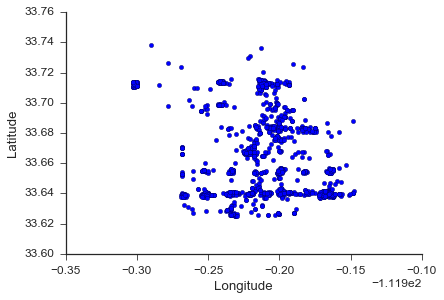

In [134]:
for ids in np.unique(d['N']['z_hood'])[1:2]: #for the unique business IDs 
    b = d['B'][d['B']['z_hood'] == ids]
    plt.scatter(b['longitude'], b['latitude'])
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    sns.despine()

When looking at data maps, it can be useful to encode a variable in the color axis of each point. In these next maps, the color of the point corresponds to the mean star rating of the business, while the size corresponds to the number of reviews that a business has.

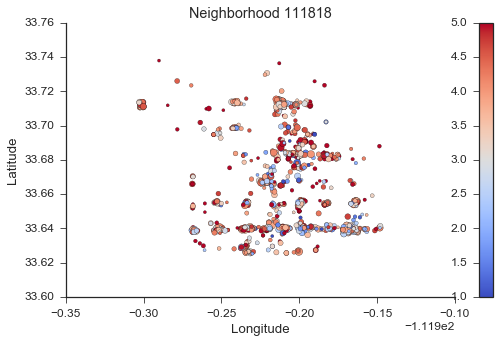

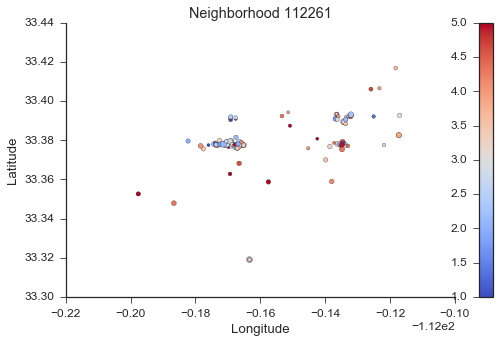

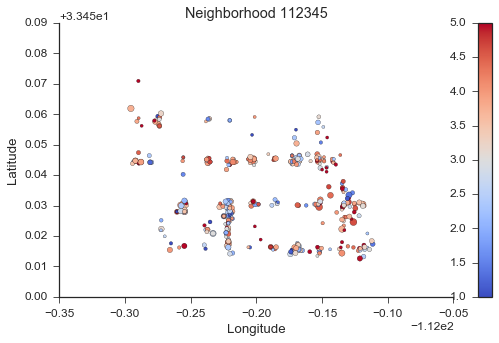

In [161]:
pylab.rcParams['figure.figsize'] = (8.0, 5.0) #use a bigger figure size for this data map

for ids in np.unique(d['N']['z_hood'])[1:4]: #for the unique business IDs 
    b = d['B'][d['B']['z_hood'] == ids]
    plt.figure()
    plt.title('Neighborhood ' + str(list(b['z_hood'])[0]))
    plt.scatter(b['longitude'], b['latitude'], c = b['mean_stars'], cmap = 'coolwarm', s = np.log10(b['review_count'])*20.0)
    plt.colorbar()
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    sns.despine()